In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import warnings

from pandas.errors import SettingWithCopyWarning
from fear_gen import extract_correct_csv
from sklearn.metrics import r2_score, cohen_kappa_score
from pyirr import intraclass_correlation

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

plt.rcParams['font.size'] = '12'
plt.rcParams['figure.figsize'] = [8, 6]

Function `anxious_subjects` that extract the higher/lower `n` subjects given the score in the `path` parameter

In [2]:
def anxious_subjects(path, n, type_='top'):
    os.chdir('..')
    valid_subjects = extract_correct_csv.extract_only_valid_subject()
    os.chdir('pyro')
    df = pd.read_csv(path).dropna().reset_index(drop=True)
    df = df[df.subject.isin(valid_subjects)]
    df['subject'] = [int(x) for x in df['subject']]
    if type_=='top':
        return df.sort_values(by=df.columns[1], ascending=False).subject[:n].values
    else:
        return df.sort_values(by=df.columns[1], ascending=False).subject[-n:].values


# Rational agent
The idea is to train *n* models where each model is trained using *n* trials.

First thing: extract *morphing level* *shock* and *rating* data of a real subject.

In [3]:
HABITUATION_TRIALS = 16

# read dataset
df = pd.read_csv('../data/newLookAtMe/newLookAtMe02.csv')
df_real = df[['shock', 'rating', 'morphing level']]
df_real['shock'] = df_real['shock'].astype(int) #setting shock as int instead of boolean
df_real['morphing level'] = [int(d==6) for d in df_real['morphing level']] # if morphing level==6 -> 1
df_real['rating'] = df_real['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1])

# remove first 16 trials
df_real=df_real[HABITUATION_TRIALS:]

## Shock expectancy simulated

Read output probability of the rational agent model, excluding the first 16 trials, and compare the results with the *rating* given by a real subject (Subject number 2 in the example below).

In [4]:
# load results of rational agent model
array_csplus_simulated = np.load('../output/pyro/complete_rational/csplus.npy',allow_pickle=True)
array_csminus_simulated = np.load('../output/pyro/complete_rational/csminus.npy',allow_pickle=True)
total_array_simulated = np.load('../output/pyro/complete_rational/total.npy',allow_pickle=True)

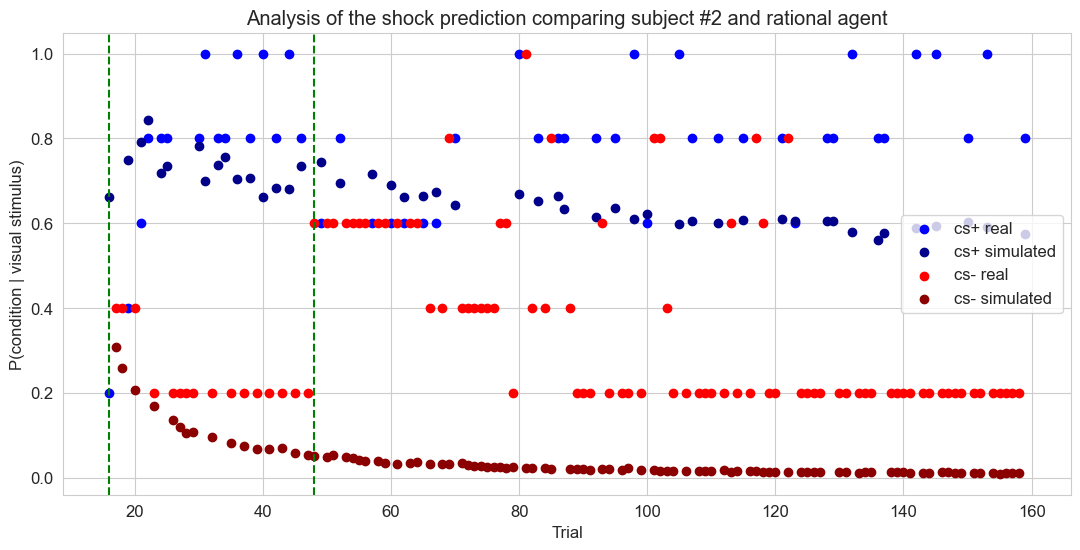

In [5]:
y_plus_real = df_real.loc[df_real['morphing level']==1].rating.values
x_plus_real = np.array(df_real.loc[df_real['morphing level']==1].index)
y_minus_real = df_real.loc[df_real['morphing level']==0].rating.values
x_minus_real = np.array(df_real.loc[df_real['morphing level']==0].index)
y_real=df_real.rating.values

fig = plt.figure(figsize=(13,6))
plt.title('Analysis of the shock prediction comparing subject #2 and rational agent')
plt.scatter(x_plus_real, y_plus_real, color='blue', label='cs+ real')
plt.scatter(array_csplus_simulated[:,0], array_csplus_simulated[:,1], color='darkblue', label='cs+ simulated')
plt.scatter(x_minus_real, y_minus_real, color='red', label='cs- real')
plt.scatter(array_csminus_simulated[:,0], array_csminus_simulated[:,1], color='darkred', label='cs- simulated')
plt.legend(loc='right')
plt.axvline(x=16, linestyle='--', color='green')
plt.axvline(x=48, linestyle='--', color='green')
plt.xlabel('Trial')
plt.ylabel('P(condition | visual stimulus)')
plt.show()


# Analysis of the correlation between the rational agent and all real subjects using Pearson

In [6]:
# extract all valid subjects
os.chdir('..')
valid_sub = extract_correct_csv.extract_only_valid_subject()
os.chdir('pyro')

In [7]:
df_correlation = pd.DataFrame(columns=['subject','pearson','r2score','pearson_disc','cohen_disc'])

path_sias = '../data/sias_score.csv'
path_lds = '../data/lds_subjects.csv'
len_sub = 6

# extract the 6 most/least generalization subjects and the 6 most/least anxious subjects
top_lds_list = anxious_subjects(path_lds, len_sub, 'top')
bot_lds_list = anxious_subjects(path_lds, len_sub, 'bot')
top_sias_list = anxious_subjects(path_sias, len_sub, 'top')
bot_sias_list = anxious_subjects(path_sias, len_sub, 'bot')

In [8]:
for sub in valid_sub:
        subj_ = extract_correct_csv.read_correct_subject_csv(sub)

        #read data of real subjects
        df_sub = pd.read_csv('../data/newLookAtMe/newLookAtMe'+subj_+'.csv')
        df_sub = df_sub[['shock', 'rating', 'morphing level']]
        df_sub['shock'] = df_sub['shock'].astype(int) #convert shock from boolean to int
        df_sub['morphing level'] = [int(d == 6) for d in df_sub['morphing level']]
        df_sub['rating'] = df_sub['rating'].replace([1, 2, 3, 4, 5], [0.2, 0.4, 0.6, 0.8, 1]) #convert vote into (0,1)
        df_sub_learn = df_sub[HABITUATION_TRIALS:] #remove habituation trials
        rating_sub = np.array(df_sub_learn['rating'])

        # rational agent output
        rating_rational = total_array_simulated
        #remove trial from rating agent simulation and real data if in one list is nan
        bad = ~np.logical_or(np.isnan(rating_sub), np.isnan(rating_rational))
        rating_sub = np.compress(bad, rating_sub)
        rating_rational = np.compress(bad, rating_rational)

        #discretization of rating rational
        round_vector = np.array([0.2, 0.4, 0.6, 0.8, 1])
        rating_rational_discr = np.round(rating_rational / 0.2) * 0.2
        rating_rational_discr = np.clip(rating_rational_discr, round_vector.min(), round_vector.max())

        # calculate pearson correlation coefficient between k-rational model and real data
        pearson = round(np.corrcoef(rating_sub,rating_rational)[0][1],2)

        # calculate r2 score between k-rational model and real data
        r2 = round(r2_score(rating_sub,rating_rational),2)

        # calculate pearson correlation coefficient between k-rational model and real data using discrete values for k-rational model
        pearson_disc = round(np.corrcoef(rating_sub,rating_rational_discr)[0][1],2)

        # calculate cohen kappa between k-rational model and real data using discrete values for k-rational model
        cohen_disc = round(cohen_kappa_score(rating_sub*10,rating_rational_discr*10),2)

        # write line
        df_tmp = pd.DataFrame({'subject':sub,'pearson':pearson,'r2score':r2,'pearson_disc':pearson_disc,'cohen_disc':cohen_disc},index=np.arange(1))
        df_correlation = pd.concat([df_correlation,df_tmp])
df_correlation['subject'] = [float(x) for x in df_correlation['subject']]
df_correlation = df_correlation.reset_index(drop=True)
sias_df = pd.read_csv('../data/sias_score.csv').drop(columns='social_anxiety')
sias_df['subject'] = [float(x) for x in sias_df['subject']]

lds_df = pd.read_csv('../data/lds_subjects.csv')
lds_df['subject'] = [float(x) for x in lds_df['subject']]

df_correlation = pd.concat([sias_df.set_index('subject'), lds_df.set_index('subject'), df_correlation.set_index('subject')], axis=1).reset_index().dropna()

`DataFrame` containing different correlation index between rational agent and real agents and the corresponding **SIAS** and **LDS** values.

In [9]:
!pwd

/Users/marcoghezzi/PycharmProjects/pythonProject/fear_gen/pyro


In [10]:
df_correlation.to_csv('../output/pyro/complete_rational/correlation.csv', index=False)

In [11]:
df_correlation.head(10)

,subject,sias_score,lds,pearson,r2score,pearson_disc,cohen_disc
0,1.0,21.0,0.201,0.31,-4.44,0.31,0.04
1,2.0,11.0,0.828,0.71,-0.39,0.70,0.25
3,4.0,12.0,0.111,0.41,-1.49,0.40,0.05
4,5.0,30.0,0.953,0.70,-0.26,0.68,0.25
5,6.0,8.0,1.312,0.72,0.18,0.72,0.28
6,7.0,25.0,0.535,0.69,-0.73,0.70,0.22
12,13.0,16.0,0.141,0.39,-3.38,0.38,0.04
14,15.0,16.0,0.693,0.63,-0.12,0.64,0.29
15,16.0,55.0,0.621,0.36,-1.30,0.34,0.07
16,17.0,16.0,-0.382,0.25,-2.57,0.26,0.09


### Scatter correlation plot between LDS values and Pearson

In [12]:
from sklearn.linear_model import LinearRegression
lds_values = df_correlation['lds'].values
pearson_values = df_correlation['pearson'].values
lds_values = lds_values[:, np.newaxis]

reg = LinearRegression()
reg.fit(lds_values, pearson_values)
predict = reg.predict(lds_values)

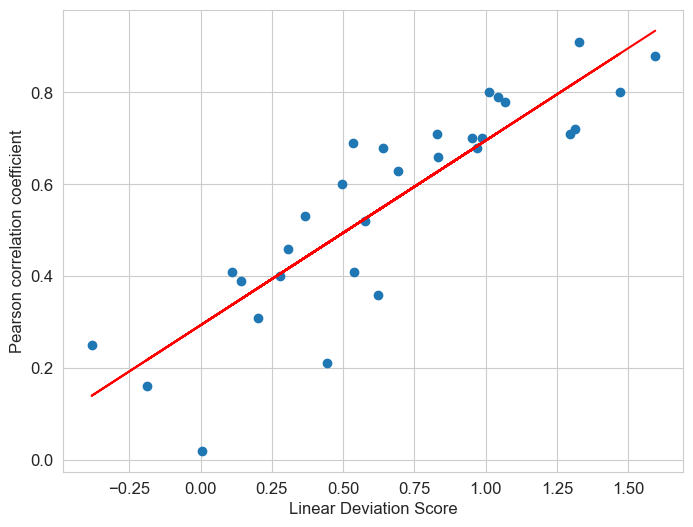

In [13]:
plt.plot(lds_values, predict, color='red')
plt.scatter(lds_values, pearson_values)
plt.xlabel('Linear Deviation Score')
plt.ylabel('Pearson correlation coefficient')
plt.show()

### Scatter correlation plot between SIAS values and Pearson

In [14]:
sias_values = df_correlation['sias_score'].values
sias_values = sias_values[:, np.newaxis]

reg_sias = LinearRegression()
reg_sias.fit(sias_values, pearson_values)
predict_sias = reg_sias.predict(sias_values)

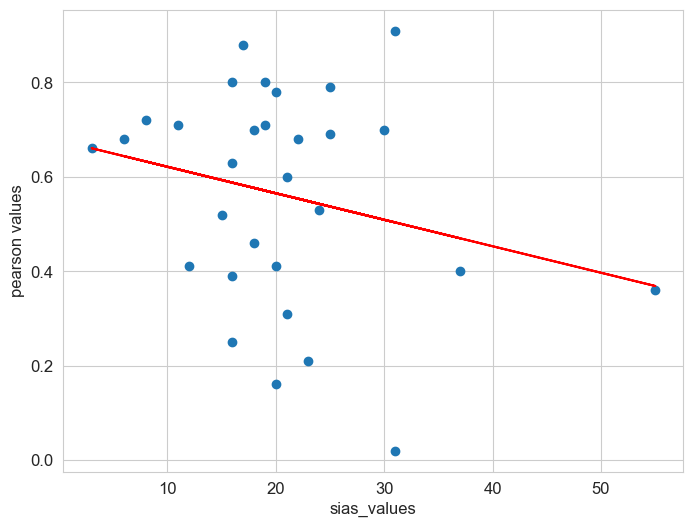

In [15]:
plt.plot(sias_values, predict_sias, color='red')
plt.scatter(sias_values, pearson_values)
plt.xlabel('sias_values')
plt.ylabel('pearson values')
plt.show()

## Analysis subject with more fear generalization vs less fear generalization

In [16]:
pearson_lds_high = df_correlation[df_correlation.subject.isin(top_lds_list)]['pearson'].median()
pearson_lds_low = df_correlation[df_correlation.subject.isin(bot_lds_list)]['pearson'].median()

r2_lds_high = df_correlation[df_correlation.subject.isin(top_lds_list)]['r2score'].median()
r2_lds_low = df_correlation[df_correlation.subject.isin(bot_lds_list)]['r2score'].median()

discrete_pearson_lds_high = df_correlation[df_correlation.subject.isin(top_lds_list)]['pearson_disc'].median()
discrete_pearson_lds_low = df_correlation[df_correlation.subject.isin(bot_lds_list)]['pearson_disc'].median()

cohen_lds_high = df_correlation[df_correlation.subject.isin(top_lds_list)]['cohen_disc'].median()
cohen_lds_low = df_correlation[df_correlation.subject.isin(bot_lds_list)]['cohen_disc'].median()

print('Correlation between 5 more/less fear gen subjects with the rational agent\n')
print('Pearson\nHigh fear gen: ',pearson_lds_high, ' Low fear gen:',pearson_lds_low)
print('\nR2score\nHigh fear gen: ',r2_lds_high, ' Low fear gen:',r2_lds_low)
print('\nPearson discrete\nHigh fear gen: ',discrete_pearson_lds_high, ' Low fear gen:',discrete_pearson_lds_low)
print('\nCohen\nHigh fear gen: ',cohen_lds_high, ' Low fear gen:',cohen_lds_low)

Correlation between 5 more/less fear gen subjects with the rational agent

Pearson
High fear gen:  0.79  Low fear gen: 0.28

R2score
High fear gen:  0.14  Low fear gen: -2.7

Pearson discrete
High fear gen:  0.76  Low fear gen: 0.28500000000000003

Cohen
High fear gen:  0.28500000000000003  Low fear gen: 0.04


## Analysis subject with higher sias score vs lower sias score

In [17]:
pearson_sias_high = df_correlation[df_correlation.subject.isin(top_sias_list)]['pearson'].median()
pearson_sias_low = df_correlation[df_correlation.subject.isin(bot_sias_list)]['pearson'].median()

r2_sias_high = df_correlation[df_correlation.subject.isin(top_sias_list)]['r2score'].median()
r2_sias_low = df_correlation[df_correlation.subject.isin(bot_sias_list)]['r2score'].median()

discrete_pearson_sias_high = df_correlation[df_correlation.subject.isin(top_sias_list)]['pearson_disc'].median()
discrete_pearson_sias_low = df_correlation[df_correlation.subject.isin(bot_sias_list)]['pearson_disc'].median()

cohen_sias_high = df_correlation[df_correlation.subject.isin(top_sias_list)]['cohen_disc'].median()
cohen_sias_low = df_correlation[df_correlation.subject.isin(bot_sias_list)]['cohen_disc'].median()

print(f'Correlation between {len_sub} more/less anxiety subjects with the rational agent\n')
print('Pearson\nHigh anxiety: ',pearson_sias_high, ' Low anxiety:',pearson_sias_low)
print('\nR2score\nHigh anxiety: ',r2_sias_high, ' Low anxiety:',r2_sias_low)
print('\nPearson discrete\nHigh anxiety: ',discrete_pearson_sias_high, ' Low anxiety:',discrete_pearson_sias_low)
print('\nCohen\nHigh anxiety: ',cohen_sias_high, ' Low anxiety:',cohen_sias_low)

Correlation between 6 more/less anxiety subjects with the rational agent

Pearson
High anxiety:  0.5449999999999999  Low anxiety: 0.67

R2score
High anxiety:  -1.0150000000000001  Low anxiety: -0.27

Pearson discrete
High anxiety:  0.54  Low anxiety: 0.665

Cohen
High anxiety:  0.195  Low anxiety: 0.24


# Intra class classification
Discretize data

In [18]:
values = np.array([0, 0.2, 0.4, 0.6, 0.8, 1])
discretized_data = np.digitize(total_array_simulated, values)
df_global = pd.DataFrame(columns=['Subject', 'Rating rational', 'Rating real'])

for sub in valid_sub:
    os.chdir('..')
    string_sub = extract_correct_csv.read_correct_subject_csv(sub)
    os.chdir('pyro')
    df_sub = pd.read_csv('../data/newLookAtMe/newLookAtMe'+string_sub+'.csv')
    df_sub = df_sub[16:]
    tmp_df = pd.DataFrame({'Subject': sub, 'Rating rational': discretized_data, 'Rating real': df_sub['rating']})
    df_global = pd.concat([df_global, tmp_df])

df_global = df_global.reset_index(drop=True)

In [19]:
valid_subjects = df_global.Subject.unique()
dict_results = {}
for x in valid_subjects:
    df_sub_ = df_global[df_global.Subject == x].dropna().drop(columns=['Subject']).reset_index(drop=True)
    df_sub_['Rating rational'] = df_sub_['Rating rational'].astype(float)
    result = intraclass_correlation(df_sub_).value
    dict_results[x] = result

In [20]:
df_icc = pd.DataFrame(list(dict_results.items()), columns=['Subject', 'ICC'])

# add ICC values to correlation df
df_all_indexes = pd.concat([df_correlation.set_index('subject'), df_icc.set_index('Subject')], axis=1).reset_index(drop=True).dropna()
df_all_indexes


,sias_score,lds,pearson,r2score,pearson_disc,cohen_disc,ICC
0,21.0,0.201,0.31,-4.44,0.31,0.04,0.172313
1,11.0,0.828,0.71,-0.39,0.70,0.25,0.648738
2,12.0,0.111,0.41,-1.49,0.40,0.05,0.300530
3,30.0,0.953,0.70,-0.26,0.68,0.25,0.644908
4,8.0,1.312,0.72,0.18,0.72,0.28,0.707388
5,25.0,0.535,0.69,-0.73,0.70,0.22,0.615005
6,16.0,0.141,0.39,-3.38,0.38,0.04,0.196695
7,16.0,0.693,0.63,-0.12,0.64,0.29,0.607578
8,55.0,0.621,0.36,-1.30,0.34,0.07,0.263697
9,16.0,-0.382,0.25,-2.57,0.26,0.09,0.131861


## Kernel Density Estimation Plot

In [21]:
first_df = pd.DataFrame(columns=['CSminus SIM', 'CSminus REAL'])
first_df['CSminus SIM'] = array_csminus_simulated[:,1]
first_df['CSminus REAL'] = y_minus_real


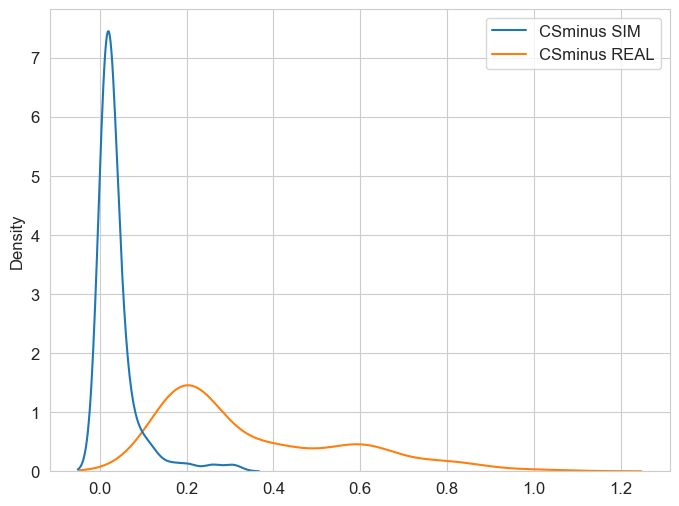

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.kdeplot(first_df)
plt.show()

In [23]:
second_df = pd.DataFrame(columns=['CSplus SIM', 'CSplus REAL'])

second_df['CSplus SIM'] = array_csplus_simulated[:,1]
second_df['CSplus REAL'] = y_plus_real

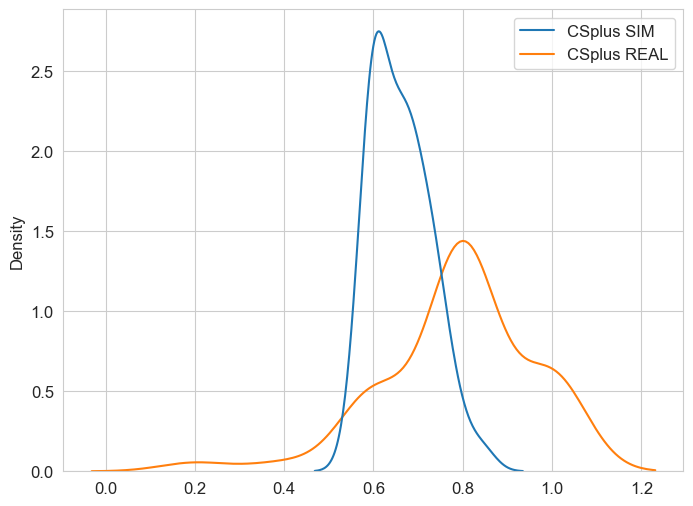

In [24]:
sns.kdeplot(second_df)
plt.show()